In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, KFold, cross_val_score
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve,\
roc_auc_score,precision_recall_fscore_support

import optuna

In [2]:
sns.set()

In [3]:
X_train = pd.read_csv(r"..\Data Set\X_train.csv")
X_test = pd.read_csv(r"..\Data Set\X_test.csv")
Y_train = pd.read_csv(r"..\Data Set\Y_train.csv")
Y_test = pd.read_csv(r"..\Data Set\Y_test.csv")

# Baseline Model - Random Forest Cl + Auto Tuning

In [4]:
cv_generator = KFold(n_splits=5, shuffle=True, random_state=0)
cv_generator_2=ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

In [7]:
def randomforest_objective(trial):
    # n_estimators = trial.suggest_int("n_estimators", 50, 200, 10) 
    # from 50 to 200, w/ steps of 10
    
    # max_depth = trial.suggest_int("max_depth", 5, 20)
    max_depth = trial.suggest_categorical('max_depth', [5,10,15]) # try 50, 100, 200
    min_samp_split = trial.suggest_int("min_samples_split", 2, 10,2)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10,2)
    #max_features = trial.suggest_int("max_features", 1, 9) # we have at most 9 features in X_train

    regr = RandomForestClassifier(
        max_depth = max_depth,
        min_samples_split = min_samp_split,
        min_samples_leaf = min_samples_leaf,
        #max_features = max_features,
        #n_estimators = n_estimators,
        n_jobs = -1,
        random_state = 0 #RANDOM_SEED,
    )

    scores = cross_val_score(
        regr, X_train, np.array(Y_train).ravel(), 
        cv = cv_generator, 
        scoring ='neg_log_loss' # classification score
    )
    return scores.mean()

 Check this [sklear page](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) for more possibilities of scoring functions.

In [9]:
study = optuna.create_study(direction="maximize")

study.optimize(randomforest_objective, n_trials=10) # try 100 or more
# More trials will increase our prob of discovering better performing models.

best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

[I 2022-01-16 12:01:18,937] A new study created in memory with name: no-name-5bf1050b-9e25-4160-aa8e-61f38594b351
[I 2022-01-16 12:01:24,212] Trial 0 finished with value: -0.23260572997358936 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 0 with value: -0.23260572997358936.
[I 2022-01-16 12:01:28,395] Trial 1 finished with value: -0.2758654554559751 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: -0.23260572997358936.
[I 2022-01-16 12:01:34,660] Trial 2 finished with value: -0.220987479960639 and parameters: {'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 2 with value: -0.220987479960639.
[I 2022-01-16 12:01:38,575] Trial 3 finished with value: -0.27611300783158804 and parameters: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 2 with value: -0.220987479960639.
[I 2022-01-16 12:01:45,112] Trial 4 finished with val

Best score: -0.21870994183493325

Optimized parameters: {'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 4}



In [16]:
# randomforest_params = tune(randomforest_objective)
# randomforest_params = {'n_estimators': 180, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 49}
clr_best_optuna = RandomForestClassifier(n_jobs=-1, random_state=0, **best_params)

In [18]:
# We could have created a callback returning the best model already fitted
# making useless the next command
clr_best_optuna.fit(X_train, np.ravel(Y_train))


# let's make the prediction
Y_pred_optuna=clr_best_optuna.predict(X_test)

In [19]:
for name,coef in zip(X_train.columns,np.ravel(clr_best_optuna.feature_importances_)):
    print("Feature Name: {}, Feature Importance: {}\n".format(name,coef))

Feature Name: person_age, Feature Importance: 0.02273202641826128

Feature Name: person_income, Feature Importance: 0.12986005274416992

Feature Name: person_home_ownership_enc, Feature Importance: 0.13248905212665402

Feature Name: person_emp_length, Feature Importance: 0.05302748888543701

Feature Name: loan_intent_enc, Feature Importance: 0.07693873922045558

Feature Name: loan_grade_enc, Feature Importance: 0.1549364019084481

Feature Name: loan_amnt, Feature Importance: 0.0515071011365107

Feature Name: loan_int_rate, Feature Importance: 0.11282859920853885

Feature Name: loan_percent_income, Feature Importance: 0.26568053835152455



# Measuring the Performance of our Model

In [20]:
clr_best_optuna.classes_

array([0, 1], dtype=int64)

In [22]:
preds= clr_best_optuna.predict(X_test)

In [23]:
# Classification Report follows the order from .classes_
# Label 0, Label 1, etc.

target_names = ['Non-Default', 'Default']
print(classification_report(Y_test,preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.92      0.99      0.95      4465
     Default       0.96      0.70      0.81      1263

    accuracy                           0.93      5728
   macro avg       0.94      0.84      0.88      5728
weighted avg       0.93      0.93      0.92      5728



Much better performance in _all_ metrics than the Logistic Regression!

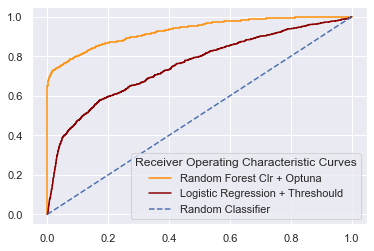

In [30]:
# Plot the ROC curve of the probabilities of default
prob_default = clr_best_optuna.predict_proba(X_test)[:,1]
fallout, sensitivity, thresholds = roc_curve(np.ravel(Y_test), prob_default)

plt.plot(fallout, sensitivity, color = 'darkorange', 
         label = "Random Forest Clr + Optuna")

roc_Logistic = pd.read_csv(r"..\Data Set\Roc_Logistic.csv")

plt.plot(roc_Logistic['fallout'], roc_Logistic['sensitivity'], color = 'darkred', 
         label = "Logistic Regression + Threshould")

plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")

plt.legend(title='Receiver Operating Characteristic Curves')

plt.show()

In [31]:
# Compute the AUC and store it in a variable
auc = roc_auc_score(Y_test, prob_default)
auc

0.9290368742901374

In [44]:
# number of loan defaults from the prediction data
n_defaults = np.unique(preds, return_counts=True)[1][1]

# default recall - True Default (Positive) Rate : proportion of correctly identified defaults
# out of all data defaults
default_recall = precision_recall_fscore_support(Y_test,preds)[1][1]

avg_loan_amnt=X_test["loan_amnt"].mean()

# Calculate the estimated impact of the new default recall rate

default_rr=n_defaults * avg_loan_amnt * (1 - default_recall)

print("The estimated average loss of misidentified defaults is {:,.4f} €".format(default_rr))
    

The estimated average loss of undetected defaults is 2,674,116.4360 €


We now see that the Logistic Regression underestimated the average loss of misidentified  defaults in 

In [50]:
print("{:,.4f} €".format(default_rr-2355525.5305))

318,590.9055 €
